In [1]:
# import libraries and load data set 
import pandas as pd

train_data = pd.read_csv("twitter_training.csv", header=None)
val_data = pd.read_csv("twitter_validation.csv", header=None)

train_data.columns = ['id', 'entity', 'sentiment', 'text']
val_data.columns = ['id', 'entity', 'sentiment', 'text']

print(train_data.head())
print(train_data.sentiment.value_counts())


     id       entity sentiment  \
0  2401  Borderlands  Positive   
1  2401  Borderlands  Positive   
2  2401  Borderlands  Positive   
3  2401  Borderlands  Positive   
4  2401  Borderlands  Positive   

                                                text  
0  im getting on borderlands and i will murder yo...  
1  I am coming to the borders and I will kill you...  
2  im getting on borderlands and i will kill you ...  
3  im coming on borderlands and i will murder you...  
4  im getting on borderlands 2 and i will murder ...  
sentiment
Negative      22542
Positive      20832
Neutral       18318
Irrelevant    12990
Name: count, dtype: int64


In [2]:
train_data.dtypes

id            int64
entity       object
sentiment    object
text         object
dtype: object

In [3]:
val_data.dtypes

id            int64
entity       object
sentiment    object
text         object
dtype: object

In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74682 entries, 0 to 74681
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         74682 non-null  int64 
 1   entity     74682 non-null  object
 2   sentiment  74682 non-null  object
 3   text       73996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


In [5]:
val_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         1000 non-null   int64 
 1   entity     1000 non-null   object
 2   sentiment  1000 non-null   object
 3   text       1000 non-null   object
dtypes: int64(1), object(3)
memory usage: 31.4+ KB


In [6]:
train_data.describe()

,id
count,74682.000000
mean,6432.586165
std,3740.427870
min,1.000000
25%,3195.000000
50%,6422.000000
75%,9601.000000
max,13200.000000


In [7]:
val_data.describe()

,id
count,1000.000000
mean,6432.088000
std,3728.310569
min,6.000000
25%,3247.750000
50%,6550.000000
75%,9661.750000
max,13197.000000


In [8]:
train_data.shape

(74682, 4)

In [9]:
val_data.shape

(1000, 4)

In [10]:
# Preprocess the Text using NLP and lable encoding
import re
import nltk
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
print(train_data['text'].isnull().sum())
print(val_data['text'].isnull().sum())

def preprocess_text(text):
    # Ensure input is a string
    if not isinstance(text, str):
        return ""

    text = text.lower()
    text = re.sub(r"http\S+|@\S+|#[A-Za-z0-9]+", "", text)
    text = re.sub(r"[^a-z\s]", "", text)
    text = " ".join(word for word in text.split() if word not in stop_words)
    return text

train_data['clean_text'] = train_data['text'].apply(preprocess_text)
val_data['clean_text'] = val_data['text'].apply(preprocess_text)

# Encode sentiment labels
le = LabelEncoder()
train_data['label'] = le.fit_transform(train_data['sentiment'])
val_data['label'] = le.transform(val_data['sentiment'])


[nltk_data] Downloading package stopwords to C:\Users\MY
[nltk_data]     DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


686
0


In [11]:
#  Vectorize, Train a Model and matrix  
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# TF-IDF
tfidf = TfidfVectorizer(max_features=5000)
X_train = tfidf.fit_transform(train_data['clean_text'])
X_val = tfidf.transform(val_data['clean_text'])

# Model
model = LogisticRegression()
model.fit(X_train, train_data['label'])

# Predict
y_pred = model.predict(X_val)

# Report
print(classification_report(val_data['label'], y_pred, target_names=le.classes_))


              precision    recall  f1-score   support

  Irrelevant       0.79      0.69      0.73       172
    Negative       0.75      0.88      0.81       266
     Neutral       0.87      0.74      0.80       285
    Positive       0.81      0.86      0.84       277

    accuracy                           0.80      1000
   macro avg       0.80      0.79      0.79      1000
weighted avg       0.81      0.80      0.80      1000



E:\anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


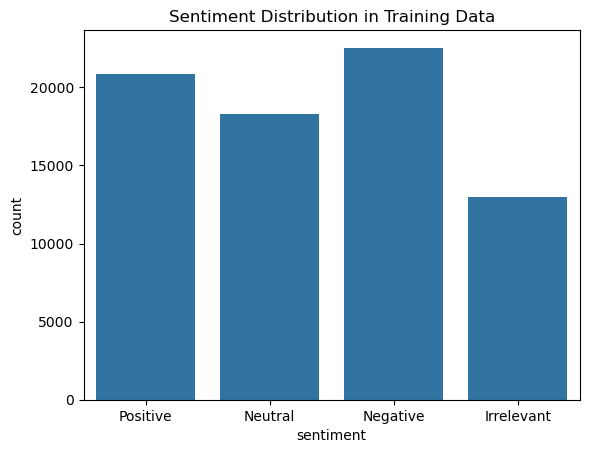

In [12]:
#  Visualizations
# Sentiment Distribution
sns.countplot(x='sentiment', data=train_data)
plt.title("Sentiment Distribution in Training Data")
plt.show()


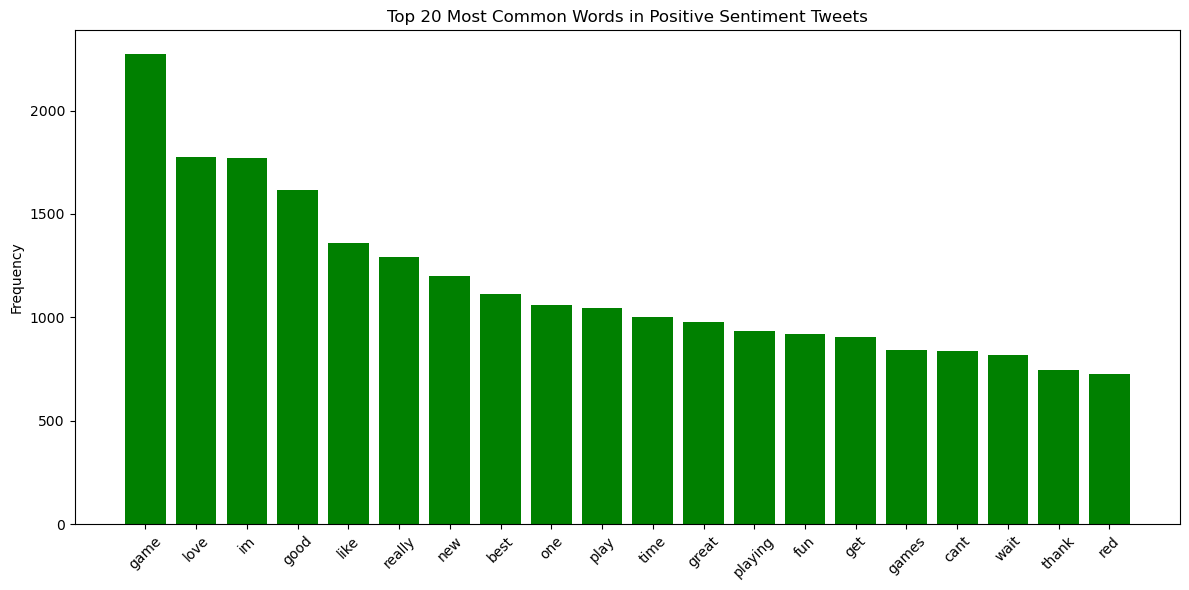

In [13]:
# Frequency Bar Chart for Positive Sentiment
from collections import Counter

# Get all words from positive sentiment tweets
positive_words = " ".join(train_data[train_data.sentiment == "Positive"]['clean_text']).split()
word_freq = Counter(positive_words)
common_words = word_freq.most_common(20)
words, counts = zip(*common_words)

# Plot the bar chart
plt.figure(figsize=(12, 6))
plt.bar(words, counts, color='green')
plt.title("Top 20 Most Common Words in Positive Sentiment Tweets")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


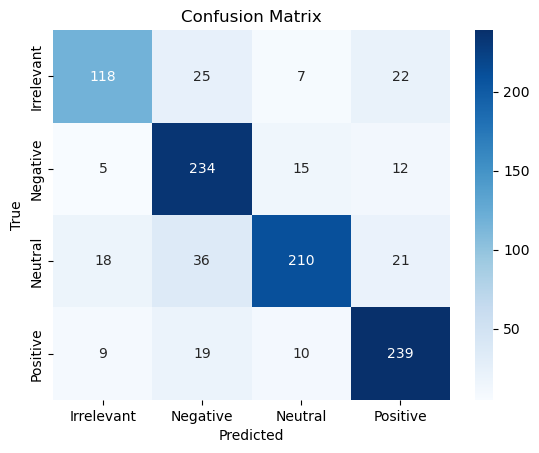

In [14]:
# Confusion Matrix using heatmap
cm = confusion_matrix(val_data['label'], y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


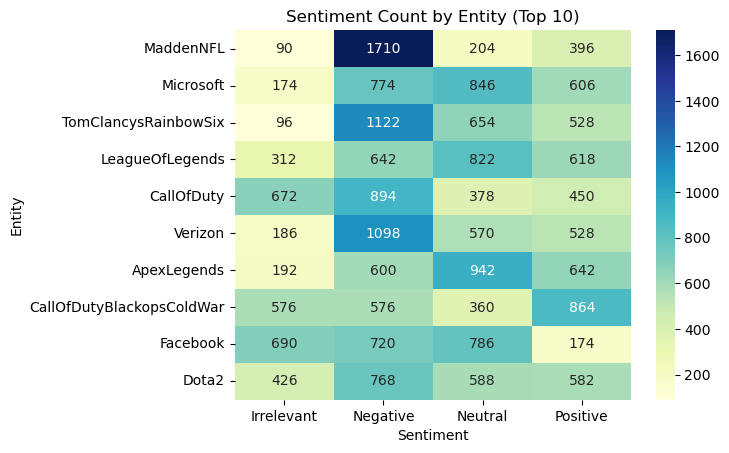

In [15]:
# Entity-Level Sentiment Breakdown by Heatmap
entity_sentiment = pd.crosstab(train_data['entity'], train_data['sentiment'])
top_entities = entity_sentiment.sum(axis=1).sort_values(ascending=False).head(10)
entity_sentiment = entity_sentiment.loc[top_entities.index]

sns.heatmap(entity_sentiment, annot=True, cmap="YlGnBu", fmt='d')
plt.title("Sentiment Count by Entity (Top 10)")
plt.ylabel("Entity")
plt.xlabel("Sentiment")
plt.show()